# Import Packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Read AnnData

Read the sharp output (.h5ad) using Scanpy.

In [2]:
adata = sc.read_h5ad("3168_example_HTO.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 6189 × 5
    obs: 'unmapped', 'barcode_sequence', 'hash_id'
    var: 'feature_name'

In [4]:
adata.obs

,unmapped,barcode_sequence,hash_id
cell_barcodes,,,
160999643764510,69,AAACCCACAACGTATC,A0307
236770352084827,55,CGCGTGAAGCGTTGTT,A0307
228052642186981,31,CTCCACAAGCAATTAG,A0310
192722521996581,72,GTCATCCGTGGTCAAG,A0307
156514624687028,28,ATAGAGACACCAGCCA,A0310
...,...,...,...
122488801056604,48,TTCCTAAGTCTGTGTA,A0309
169012825811803,36,ACTTTGTGTATCGGTT,A0307
160919094180588,79,AAAGGTAGTAATGTGA,A0310


# Initial Hashtag Distribution

Note that _doublet_ here actually means either _true doublet_ or _negative_ (the demultiplexing algorithm is sometimes unable to make a clear call especially when there are too small number of molecule counts present).

In [5]:
adata.obs.groupby("hash_id").size()

hash_id
A0306       576
A0307       911
A0308       237
A0309       737
A0310      2036
Doublet    1692
dtype: int64

In [6]:
# percentage
adata.obs.groupby("hash_id").size() / adata.shape[0] * 100.0

hash_id
A0306       9.306835
A0307      14.719664
A0308       3.829375
A0309      11.908224
A0310      32.897075
Doublet    27.338827
dtype: float64

# QC

## Find Cutoff Point

When there are too small number of molecule counts present, the algorithm might not be able to correctly classify (e.g. calling negative as singlet).

To remedy this issue, we are going to plot a histogram of UMI counts and try to find a cutoff point where anything below this cutoff point will be labeled as negative. Please note that this is just one simple and naive way to correct the problem. You might want to try more sophisticated methods.

In [7]:
# total UMIs per cell barcode
adata.obs["total_umis"] = adata.X.sum(axis=1).A1

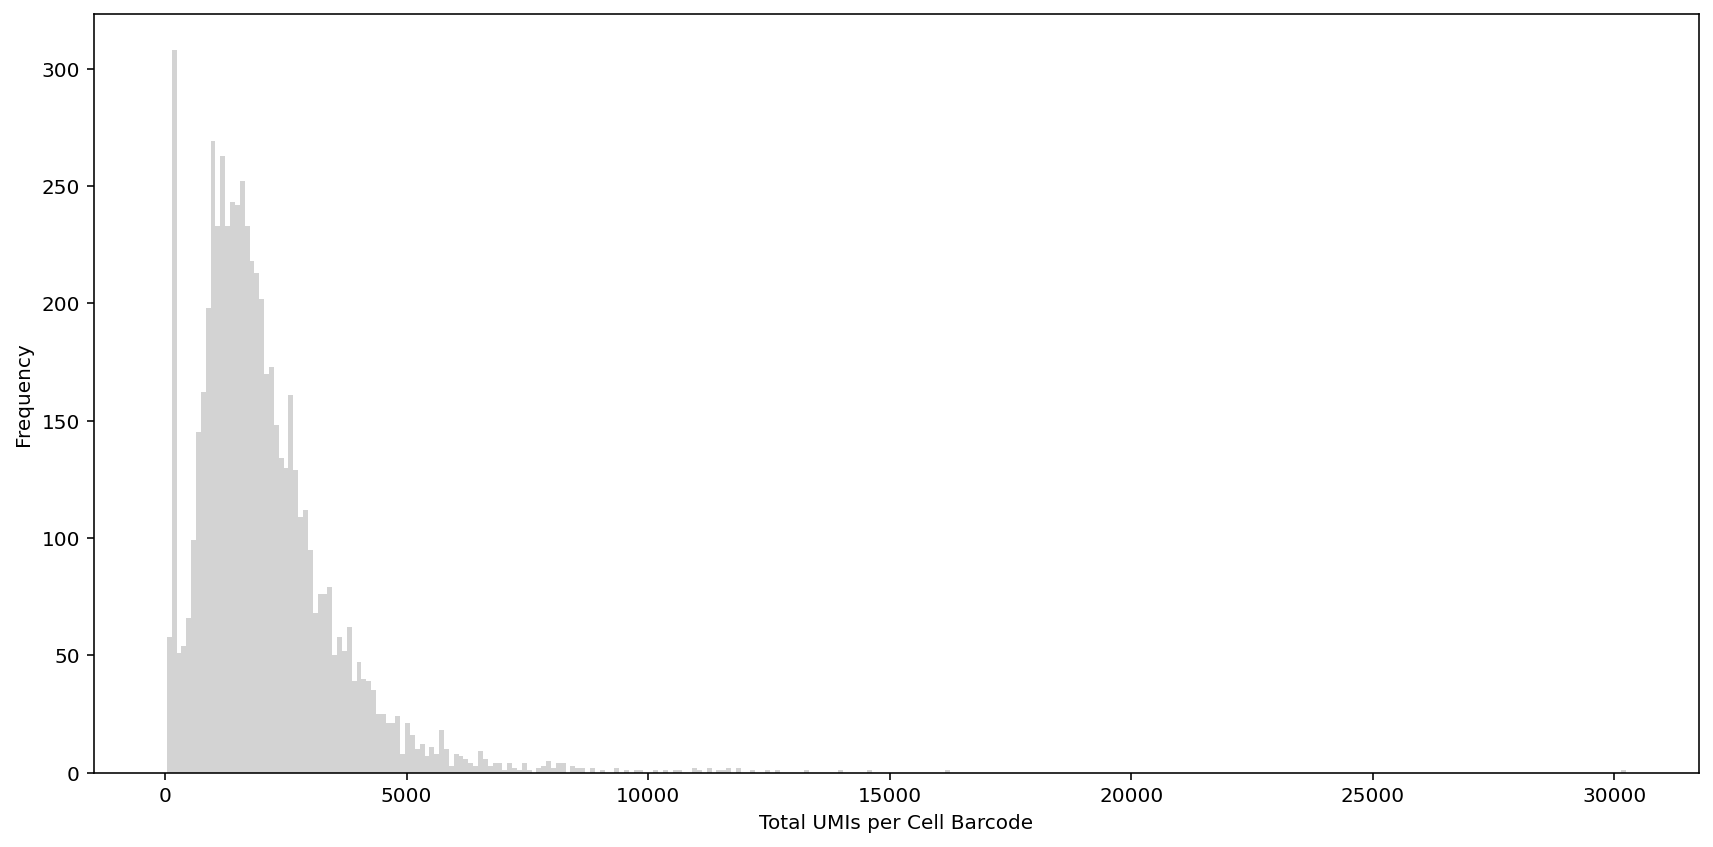

In [8]:
fig, ax = plt.subplots(figsize=(12, 6), facecolor="white")

freqs, bins, patches = ax.hist(adata.obs["total_umis"], bins=300, color="lightgray")

ax.set_xlabel("Total UMIs per Cell Barcode")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [9]:
# find the max frequencies (for visualization purpose)
max_freq = np.max(freqs)
max_freq

308.0

In [10]:
# define histogram function
def plot_histogram(zoom_in_range=None, cutoff=None):
    
    fig, ax = plt.subplots(figsize=(12, 6), facecolor="white")

    ax.hist(adata.obs["total_umis"], bins=300, color="lightgray", alpha=0.7, rwidth=0.95)
    if cutoff:
        ax.vlines(x=cutoff, ymin=0, ymax=max_freq, color="red", linewidth=3, linestyle="--", label="cutoff")
        ax.legend()
        
    ax.set_xlabel("Total UMIs per Cell Barcode")
    ax.set_ylabel("Frequency")

    if zoom_in_range:
        ax.set_xlim(zoom_in_range)
        ax.set_xticks(np.arange(zoom_in_range[0], zoom_in_range[1], 100))

    ax.xaxis.set_major_formatter(matplotlib.ticker.EngFormatter())
    ax.tick_params(axis="x", rotation=90)
    ax.grid(b=False)

    plt.tight_layout()
    plt.show()

Zoom in to the region where total UMI per cell barcode is between 0 and 5000

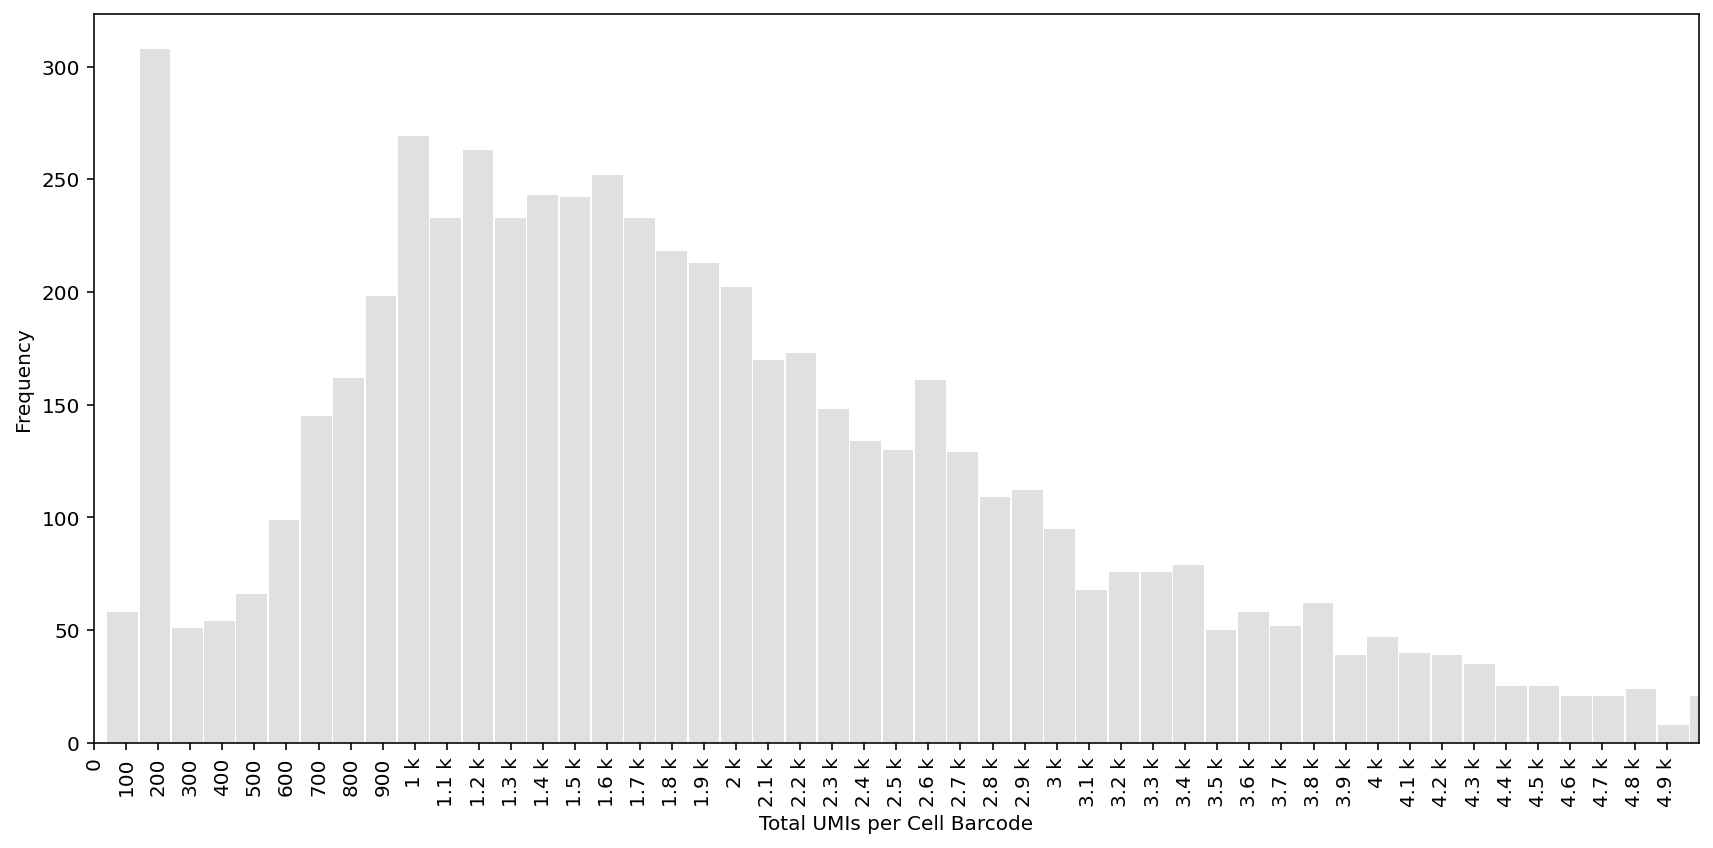

In [11]:
plot_histogram(
    zoom_in_range=[0, 5000]
)

Based on the histogram above, we will set the cutoff to be 250.

In [12]:
cutoff = 250

In [13]:
adata[adata.obs.total_umis < cutoff].to_df()

,A0306-TATGCTGCCACGGTA,A0307-GAGTCTGCCAGTATC,A0308-TATAGAACGCCAGGC,A0309-TGCCTATGAAACAAG,A0310-CCGATTGTAACAGAC
cell_barcodes,,,,,
195613993654131,18,36,25,30,46
126904046045613,32,82,10,43,49
165789559806317,24,43,7,41,35
130691221834988,22,40,6,46,52
200983507822493,16,53,12,41,68
...,...,...,...,...,...
130204815972214,5,5,1,11,199
204198559038884,5,8,1,5,174
230809056426718,6,15,4,14,22


Redraw the histogram with the red dashed cutoff line at 250.

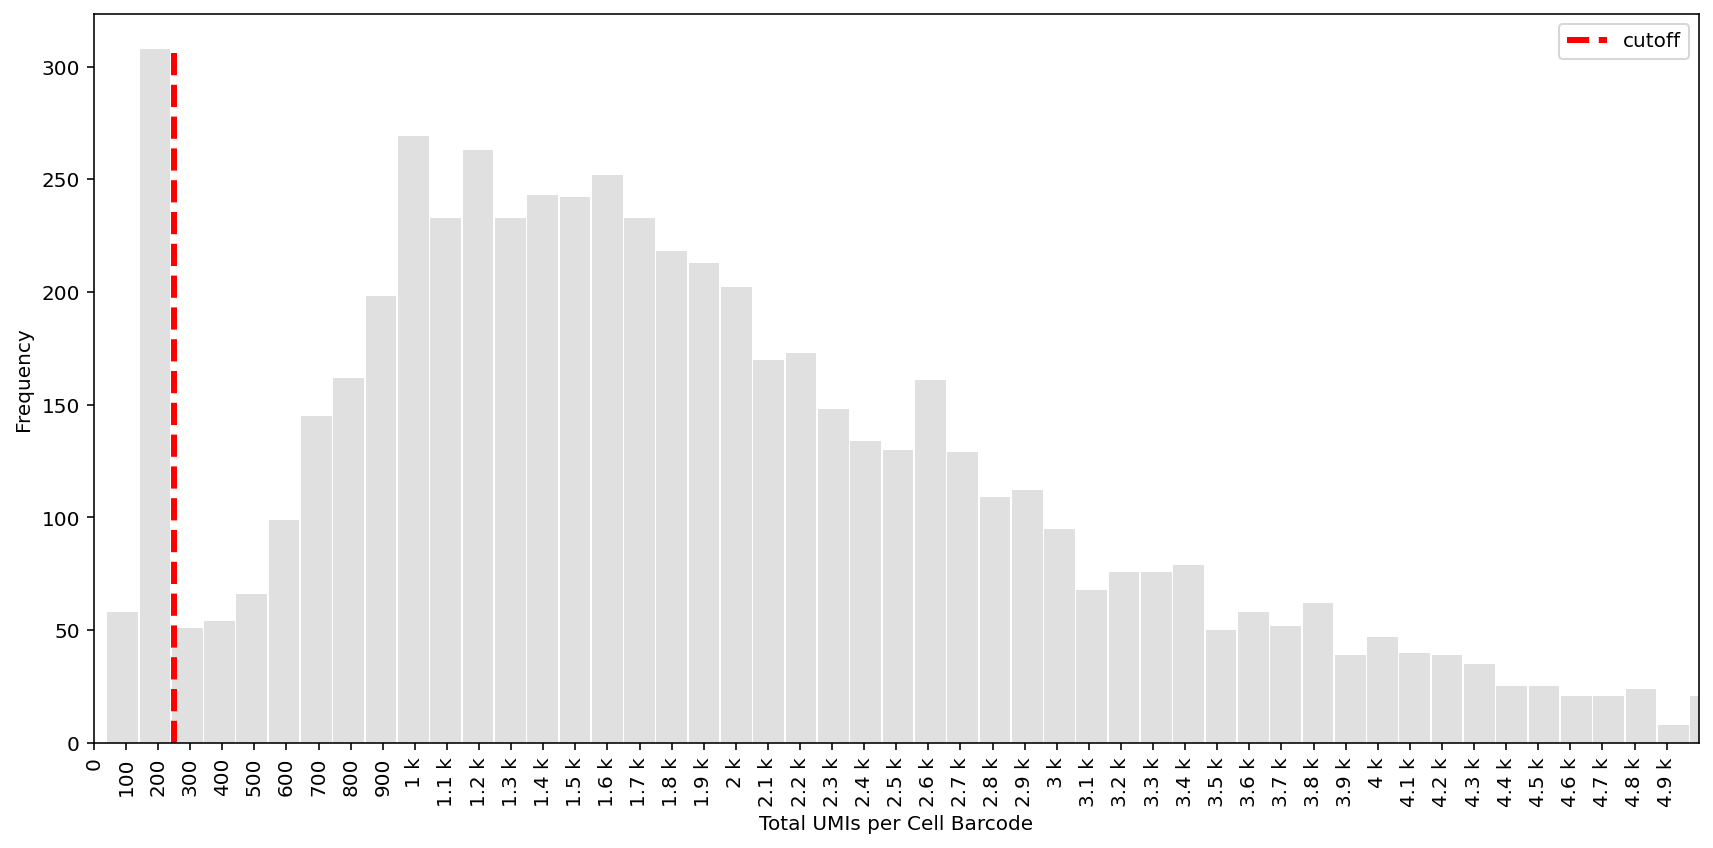

In [14]:
plot_histogram(
    zoom_in_range=[0, 5000],
    cutoff=cutoff
)

## Mark as Negative

Now we're going to mark anything below the found cutoff point as negative.

In [15]:
# add a new category "Negative" if doesn't exist yet
if not "Negative" in adata.obs.hash_id.unique():
    adata.obs["hash_id"] = adata.obs["hash_id"].cat.add_categories("Negative")    

In [16]:
adata.obs.hash_id[ adata.obs.total_umis < cutoff ] = "Negative"

## Post-Correction Hashtag Distribution

Check the hashtag distribution again.

In [17]:
adata.obs.groupby("hash_id").size()

hash_id
A0306        573
A0307        904
A0308        236
A0309        734
A0310       2000
Doublet     1370
Negative     372
dtype: int64

In [18]:
# percentage
adata.obs.groupby("hash_id").size() / adata.shape[0] * 100.0

hash_id
A0306        9.258362
A0307       14.606560
A0308        3.813217
A0309       11.859751
A0310       32.315398
Doublet     22.136048
Negative     6.010664
dtype: float64

## Doublets

Check if doublets look like true doublets.

In [19]:
adata[ adata.obs.hash_id == "Doublet" ].to_df().sample(77, random_state=777)

,A0306-TATGCTGCCACGGTA,A0307-GAGTCTGCCAGTATC,A0308-TATAGAACGCCAGGC,A0309-TGCCTATGAAACAAG,A0310-CCGATTGTAACAGAC
cell_barcodes,,,,,
134448003005214,27,1996,6,19,927
155973277604211,13,232,14,340,323
240000198171421,36,24,1594,1469,1550
204902618777334,145,221,46,138,157
157684166507318,14,1169,7,17,2702
...,...,...,...,...,...
120847171439851,25,1786,8,27,843
197211689274669,2578,17,10,33,2126
121963893610789,14,27,5,887,1950


# Retrieve Cell Barcodes for Each Hashtag

For example, let's retrieve all the cell barcodes whose sample of origin is `A0306`.

In [20]:
adata[ adata.obs.hash_id == "A0306" ]

View of AnnData object with n_obs × n_vars = 573 × 5
    obs: 'unmapped', 'barcode_sequence', 'hash_id', 'total_umis'
    var: 'feature_name'

In [21]:
adata[ adata.obs.hash_id == "A0306" ].obs

,unmapped,barcode_sequence,hash_id,total_umis
cell_barcodes,,,,
227494308232429,134,CTGCTCAGTTATCTGG,A0306,6527
165251749898653,45,AGAAGCGTCCTCACTG,A0306,1948
231289958651827,47,CAAGGGATCACGTCCT,A0306,2975
169107468467619,23,ACTACGACAGATCCAT,A0306,559
134377557941028,49,TCATTACCACCGGAAA,A0306,1326
...,...,...,...,...
120730030631332,56,TTTACCACAGGCACAA,A0306,2130
230600509345181,48,CATTGTTGTATACCTG,A0306,2254
165248421227821,10,AGAAGTAGTAACCAGG,A0306,495


## For SEQC

In [22]:
cb_seqc = adata[ adata.obs.hash_id == "A0306" ].obs.index.values

In [23]:
cb_seqc

array(['227494308232429', '165251749898653', '231289958651827',
       '169107468467619', '134377557941028', '169175113714918',
       '241109220649757', '134377538214749', '120728791169963',
       '170120275770598', '170738731376043', '165851864616221',
       '130003758180581', '196172038978862', '165260097936307',
       '230600481892140', '157469148928947', '204770951981926',
       '156572856211364', '121887358602611', '161942504066406',
       '164623791048540', '204763032897316', '239997916728035',
       '195959585400740', '161461172394228', '165173232298228',
       '157070656915180', '231220165860251', '199823176449318',
       '161529235651372', '232319542736820', '122427482159963',
       '227509447650598', '157469134929254', '205861470494043',
       '195613974482148', '133828561221990', '195634079649054',
       '191208161728796', '201463738874718', '122378492198125',
       '121946445404083', '131227065150836', '120726912092062',
       '126843064867125', '1708694324708

## For Cell Ranger

You need to add a GEM well suffix (e.g. `-1`).

In [24]:
cb_cellranger = (adata[ adata.obs.hash_id == "A0306" ].obs.barcode_sequence + "-1").values

In [25]:
cb_cellranger

array(['CTGCTCAGTTATCTGG-1', 'AGAAGCGTCCTCACTG-1', 'CAAGGGATCACGTCCT-1',
       'ACTACGACAGATCCAT-1', 'TCATTACCACCGGAAA-1', 'ACTGCAACATGACTAC-1',
       'CCCAACTGTAGCGATG-1', 'TCATTACGTTAGGGTG-1', 'TTTACGTAGGATGCGT-1',
       'ACGTAACCACCTCTAC-1', 'ACCAAACGTTGGCCGT-1', 'AGGGTGAGTCTACATG-1',
       'TGATCTTTCACCATAG-1', 'GAACGTTAGAGTCAGC-1', 'AGAACCTGTTGGGCCT-1',
       'CATTGTTTCTGCTAGA-1', 'ATCTTCAAGTCGGCCT-1', 'GCATCTCTCCACGGAC-1',
       'ATACTTCGTCTGTCAA-1', 'TTGGGATAGGAACGCT-1', 'AACAAAGGTTTACGAC-1',
       'AGTTAGCCAGAATGTA-1', 'GCATGATTCGGATAAA-1', 'CCAATTTCAAGAGTAT-1',
       'GAATAGAGTCACTCAA-1', 'AAGGAATTCACGATCA-1', 'AGATAGATCGACATCA-1',
       'ATGGGTTAGGTATTGA-1', 'CAAAGAATCCTGGCTT-1', 'GGTTCTCGTACTCAAC-1',
       'AAGCATCAGGATGAGA-1', 'CACAGATTCATTTCCA-1', 'TTCGATTCAGTTGGTT-1',
       'CTGCGAGTCTCCCAAC-1', 'ATCTTCATCCTTCGAC-1', 'GCCTGTTTCAAGCGTT-1',
       'GATCATGGTGAACTAA-1', 'TCTTTGATCCATAGAC-1', 'GATCCCTTCAGACATC-1',
       'GTTCTATCATGGAATA-1', 'GGCTGTGCAGCTGGTC-1', 